# Background Replacement Tests | proximity-quadrotor-learning

https://github.com/idsia-robotics/proximity-quadrotor-learning

## Settings

In [ ]:
################################
### KNOWN IMPORTS
######

import math
import os
import time
import errno
import random
import sys
import gc
from datetime import datetime

# %tensorflow_version 1.x
import tensorflow as tf

# when importing keras, please notice:
#   https://stackoverflow.com/a/57298275/10866825
#   https://www.pyimagesearch.com/2019/10/21/keras-vs-tf-keras-whats-the-difference-in-tensorflow-2-0/

from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model, to_categorical
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint

# !pip install resnet
# import resnet as kr

import numpy as np
import pandas as pd
import sklearn as sk
import sklearn.metrics

import cv2
from PIL import Image
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
%matplotlib inline

# -- for GradCAM
!pip install tf-keras-vis
from tf_keras_vis.utils import normalize
from tf_keras_vis.gradcam import Gradcam
from matplotlib import cm


################################
### PATHS
######

try:
  import google.colab
  IN_COLAB = True
  from google.colab import drive
  from google.colab.patches import cv2_imshow
  drive.mount('/content/drive')
  src_folder = '/content/drive/My Drive/_ USI/_ THESIS/proximity-quadrotor-learning/marco-test/src/'
  models_folder = '/content/drive/My Drive/_ USI/_ THESIS/proximity-quadrotor-learning/trained-models/'
  pickles_folder = '/content/drive/My Drive/_ USI/_ THESIS/proximity-quadrotor-learning/dataset/Whole Dataset/pickles/'
  new_models_folder = '/content/drive/My Drive/_ USI/_ THESIS/proximity-quadrotor-learning/marco-test/new-models/'
  new_datasets_folder = '/content/drive/My Drive/_ USI/_ THESIS/proximity-quadrotor-learning/marco-test/new-datasets/'
  visualization_folder = '/content/drive/My Drive/_ USI/_ THESIS/proximity-quadrotor-learning/marco-test/visualization/'
  videos_folder = '/drive/My Drive/_ USI/_ THESIS/proximity-quadrotor-learning/marco-test/visualization/video/'
except:
  # this file goes into 'proximity-quadrotor-learning/marco-test' folder
  IN_COLAB = False
  from cv2 import imshow as cv2_imshow
  src_folder = 'src/'
  models_folder = '../trained-models/' # Dario's original trained models (https://drive.switch.ch/index.php/s/Idsyf8WIwQpvRMF)
  pickles_folder = '../dataset/Whole Dataset/pickles/' # Dario's original dataset (https://drive.switch.ch/index.php/s/8clDQNH645ZjWDD)
  new_models_folder = 'new-models/'
  new_datasets_folder = 'new-datasets/'
  visualization_folder = 'visualization/'
  videos_folder = 'visualization/video/'


chosen_model = 1
original_model_path = models_folder + 'v' + str(chosen_model) + '_model_train_size_50000_rep_1.h5'
pickle_train_path = pickles_folder + 'version' + str(chosen_model) + '/train.pickle'
pickle_test_path = pickles_folder + 'version' + str(chosen_model) + '/test.pickle'



################################
### CUSTOM IMPORTS
######

sys.path.append(src_folder)
import general_utils
import keras_utils

import importlib
importlib.reload(general_utils)
importlib.reload(keras_utils)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


<module 'keras_utils' from '/content/drive/My Drive/_ USI/_ THESIS/proximity-quadrotor-learning/marco-test/src/keras_utils.py'>

## Dataset

Here, **regression variables** in the ground truth are used to retrieve **classification variables** (added to the dataset `y`) by discretizing continous values accordingly to arbitrary defined bin intervals. Train set size is reduced to avoid overloads.

In [ ]:
dataset_start_index = 24000
dataset_keep_ratio = 0.5
orig_img, orig_x, orig_y, orig_actual, orig_odom = general_utils.get_dataset_from_pickle(pickle_train_path, dataset_start_index, dataset_keep_ratio)

Reading dataset from /content/drive/My Drive/_ USI/_ THESIS/proximity-quadrotor-learning/dataset/Whole Dataset/pickles/version1/train.pickle
dataset original shape: (63726, 3)
dataset keep shape: 	(31863, 3)
img_data shape: 	(31863,)
x_data shape: 		(31863, 60, 108, 3)
y_data shape: 		(31863, 4)
odom_dataset shape: 	(31863, 2)
y_data_for_network shape cannot be computed because elements in the list have different shapes:
y_data_for_network number of variables 				 8
y_data_for_network single regression variable (0:4) 		 (31863,)
y_data_for_network single classification variable (4:8) 	 (31863, 3)


### Dataset complete overview

In [ ]:
step = 100
ncols = 10
nrows = 10
size = (nrows * ncols)

for start in range(0, len(orig_img), step * size):
  fix, ax = plt.subplots(nrows, ncols, figsize=(nrows*5, ncols*3), subplot_kw={'xticks': [], 'yticks': []})
  end = start + step * size
  for count, i in enumerate(range(start, end, step)):
    ax[count//10, count%10].imshow(orig_img[i])

Output hidden; open in https://colab.research.google.com to view.

## Human segmentation

### Pose exploration over images

In [ ]:
# ## Variables distribution and min/max

# for vi, vn in enumerate(general_utils.variables_names[0:4]):
#   print('{0} \t min={1}, max={2}'.format(vn, np.min(orig_y[vi]), np.max(orig_y[vi])))
#   plt.hist(orig_y[vi])
#   plt.title(vn)
#   plt.show()

In [ ]:
# corners = np.where(orig_y[1] > 1)[0][:10]
# # corners = list(range(0, orig_img.shape[0], 100))[:30]

# ncols = 5
# nrows = int(np.ceil(len(corners)/ncols))
# fig, ax = plt.subplots(nrows,ncols, figsize = (ncols*5,nrows*3), subplot_kw={'xticks': [], 'yticks': []})


# for counter, index in enumerate(corners):
#   if(len(corners) == 1 and ncols == 1):
#     cell = ax
#   elif(nrows == 1):
#     cell = ax[counter]
#   else:
#     cell = ax[counter//ncols, counter%ncols]

#   cell.imshow(orig_img[index])
#   cell.set_title('f{} | x:{:.2f}, y:{:.2f}, z:{:.2f}, w:{:.2f}'.format(index, orig_y[0][index], orig_y[1][index], orig_y[2][index], orig_y[3][index]))

In [ ]:
# from matplotlib.patches import Rectangle
# from PIL import Image

# idx = 340
# x = orig_y[0][idx]
# y = orig_y[1][idx]
# z = orig_y[2][idx]
# w = orig_y[3][idx]
# print('x', x)
# print('y', y)
# print('z', z)

# plt.imshow(orig_img[idx])


# # r_size, depends on x
# r_base_size = (8, 20)
# r_size = (1.5*r_base_size[0]/x, 1.5*r_base_size[1]/x)

# # r_x, depends on y
# r_x = - 70 * y + general_utils.image_width / 2

# # r_y, depends on z and x
# r_y = general_utils.image_height / 2

# # r_coords, depends on r_x, r_y and r_size
# r_coords = (r_x, r_y) - r_size[0]/2

# rect = Rectangle(r_coords,r_size[0],r_size[1],linewidth=2,edgecolor='r',facecolor='none') # create a Rectangle patch
# ax = plt.gca() # get the current reference
# ax.add_patch(rect) # add the patch to the Axes

### Canny Edge Detection

Taken and adapted from [this](https://stackoverflow.com/questions/29313667/how-do-i-remove-the-background-from-this-kind-of-image) Stackoverflow answer.

#### Overview

Show how the algorithm performs on the dataset images. 

The most important thing is to set proper `min` and `max` thresholds for the [cv2 Canny function](https://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_imgproc/py_canny/py_canny.html). The gradient `G` of each pixel is computed:
- if `G < min` it is **not** considered as an edge
- if `G > max` it is **always** considered as an edge
- if `min < G < max` it will be considered as an edge **only if** it is connected to another edge (which is an edge for sure)

In [ ]:
### Multiple images background removal (blank or transparent replacement)

start = 0000
stop = 10000
step = 50

canny_min = 100
canny_max= 400

ncols = 10
nplotted = (stop - start) / step
nrows = np.ceil(nplotted / ncols).astype(int)
f, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols*5, nrows*3), subplot_kw={'xticks': [], 'yticks': []})

for counter, index in enumerate(range(start, stop, step)):
  if(nplotted == 1 and ncols == 1):
    cell = ax
  elif(nrows == 1):
    cell = ax[counter]
  else:
    cell = ax[counter//ncols, counter%ncols]
  
  try:
    orig = orig_img[index]
    edit = general_utils.image_background_replace_canny(orig, canny_min, canny_max, l2gradient = True, 
                                    blur = 13, dilate_iter = 5, erode_iter = 5,
                                    transparent = False, replace_bg_images = None, save = False)
    cell.imshow(edit[0]) # it returns a single element array since 'replace_bg_images' is None
    cell.set_title('f {}'.format(index))
  except:
    cell.set_facecolor('#ff8989')

# f.savefig(visualization_folder + 'removebg-{0}-{1}.jpg'.format(canny_min, canny_max))
# plt.close(f)

Output hidden; open in https://colab.research.google.com to view.

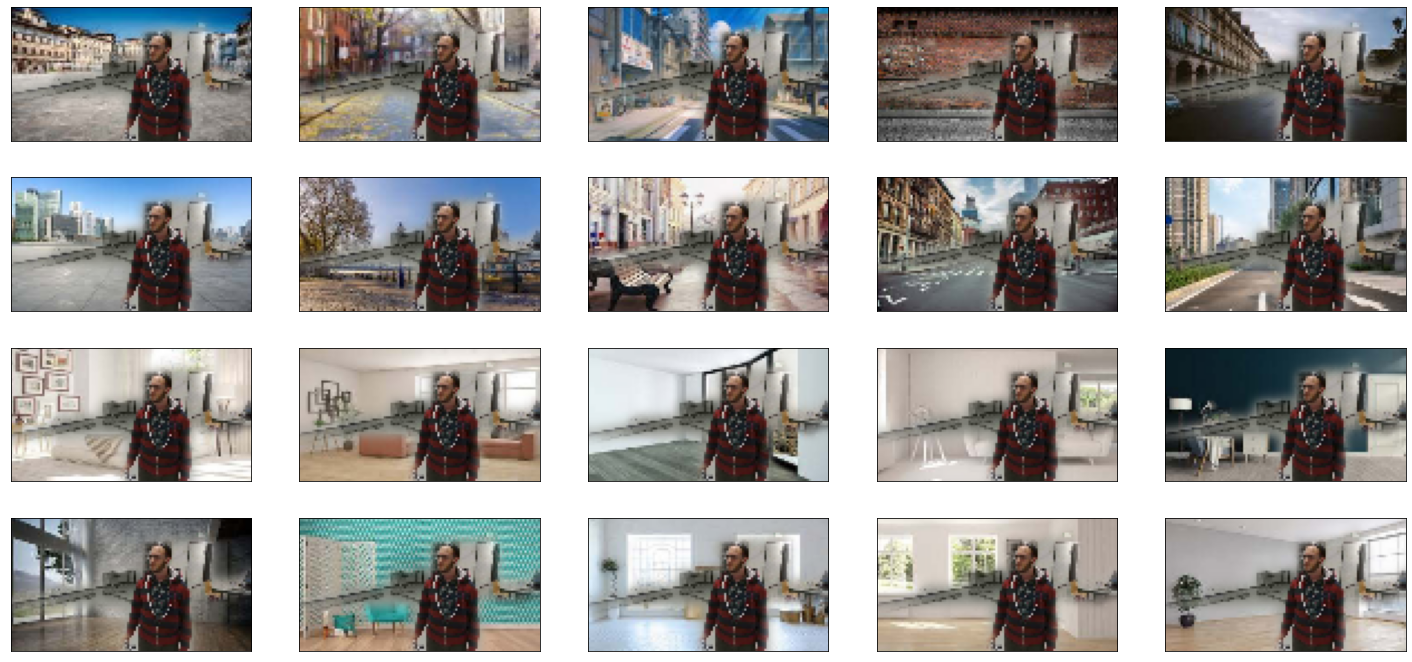

In [ ]:
### Single image background replacement

replace_imgs = general_utils.load_images_from_folder(new_datasets_folder + 'inputs/backgrounds-20')

edit_images = general_utils.image_background_replace_canny(
    orig_img[250], canny_min, canny_max, l2gradient = True, 
    blur = 13, dilate_iter = 5, erode_iter = 5, 
    debug = False, transparent = False, replace_bg_images = replace_imgs,
    save = False, save_folder = visualization_folder + 'removebg/', save_name = 'removebg_prova'
)

ncols = 5
nrows = int(np.ceil(len(edit_images)/ncols))
fig, ax = plt.subplots(nrows, ncols, figsize=(ncols*5, nrows*3), subplot_kw={'xticks': [], 'yticks': []})

for count, ei in enumerate(edit_images):
  if len(edit_images) == 1 and ncols == 1:
    cell = ax
  elif nrows == 1:
    cell = ax[count]
  else:
    cell = ax[count//ncols, count%ncols]

  cell.imshow(ei)

#### Export modified dataset

In [ ]:
# ### Export
# bg_type = '6'
# replace_imgs = general_utils.load_images_from_folder(new_datasets_folder + 'inputs/backgrounds-' + bg_type)
# ninputs = len(orig_img) # samples considered into orig_img dataset
# nbackgrounds = len(replace_imgs) if replace_imgs is not None else 1

# count_total = ninputs * nbackgrounds
# skip_frames = 5 # considering original inputs
# log_each = 1000 # considering original inputs and skip
# max_per_dataframe = 60000 # number of sample each dataframe can have

# save_each = int(np.ceil(max_per_dataframe / nbackgrounds))
# frames_enumerator = range(0, ninputs, skip_frames)

# count_real = len(frames_enumerator) * nbackgrounds
# part_total = int(np.ceil(count_real / (save_each * nbackgrounds))) # number of dataframes that will be saved
# part_current = 0 # current saved dataframe
# timestr = time.strftime("%Y%m%d_%H%M%S")

# print('orig_imgs: \t', len(orig_img))
# print('log each: \t', log_each)
# print('save each: \t', save_each, '\n')

# print('replace_imgs: \t', nbackgrounds)
# print('count_total: \t', count_total, '\n')

# print('skip_frames: \t', skip_frames)
# print('count_real: \t', count_real)
# print('part_total: \t', part_total, '\n')


# edited = [] # new images with no background
# errors = [] # index only of error frames
# blank = np.ones((general_utils.image_height, general_utils.image_width, 3)) # for errors



# def save_pickle(data, timestr, folder, count_total, part_current, part_total):
#   picklename = '{0}_replacebg_df{1}_{2}of{3}.pickle'.format(timestr, count_total, part_current, part_total)
#   exportpath = folder + picklename
#   general_utils.create_folder_if_not_exist(folder)

#   exportdf = pd.DataFrame(list(data))
#   exportdf.to_pickle(exportpath)
#   print('Export complete in', exportpath)



# print('Exporting...')
# if replace_imgs is None:
#   dataset_notes = 'remove background - start {0} total {1}'.format(dataset_start_index, count_real)
# else:
#   dataset_notes = 'replace {0} samples (start{1}, skip{2} = {3}) with {4} backgrounds - total {5}'.format(ninputs, dataset_start_index, skip_frames, ninputs//skip_frames, bg_type, count_real)

# dataset_folder = new_datasets_folder + dataset_notes + '/'

# for count, frame_index in enumerate(frames_enumerator):
  
#   if count != 0 and count % log_each == 0:
#     print('Progress: {0}/{1}'.format(frame_index, ninputs))

#   if count != 0 and count % save_each == 0:
#     part_current += 1
#     save_pickle(edited, timestr, dataset_folder, count_real, part_current, part_total)
#     del edited # delete object for freeing memory
#     gc.collect() # tells the garbage collector to free unused memory
#     edited = [] # reinstantiate result array

#   target = orig_actual[frame_index,0:4]
#   odom = orig_odom[frame_index]
  
#   try:
#     images = general_utils.image_background_replace(
#         orig_img[frame_index], canny_min = 100, canny_max = 400, l2gradient = True, 
#         blur = 13, dilate_iter = 5, erode_iter = 5, 
#         transparent = False, replace_bg_images = replace_imgs
#     )
#   except:
#     # images = [blank] # otherwise, indexes become a mess
#     errors.append(frame_index)
  
#   for img in images:
#     edited.append((img, target, odom))


# # remaining samples
# part_current += 1
# save_pickle(edited, timestr, dataset_folder, count_real, part_current, part_total)
# del edited # delete object for freeing memory
# gc.collect() # tells the garbage collector to free unused memory


# print('\nCOMPLETED')
# print('errors shape', np.shape(errors))
# print('\nerrors: ', errors)

### GrabCut Algorithm

Taken and adapted from [cv2 documentation](https://docs.opencv.org/4.1.2/d8/d83/tutorial_py_grabcut.html).

In [ ]:
### Image selection and manual poses insertion

sample_images = [0, 6000, 12000, 18000, 24000, 30000, 37, 1650, 1850, 3850, 5500, 8700]
sample_poses = [(44, 10), (28, 13), (22, 12), (53, 15), (67, 10), (42, 14), (0, 20), (34, 42), (37, 0), (49, 4), (41, 10), (37, 14)]
box_width = 10
box_height = 35

#### Demo

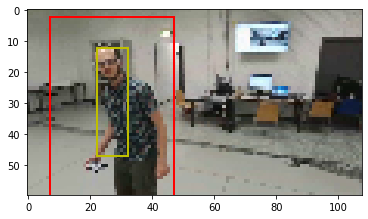

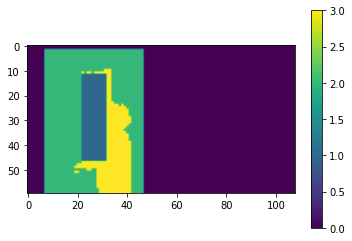

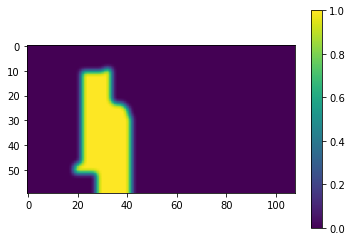

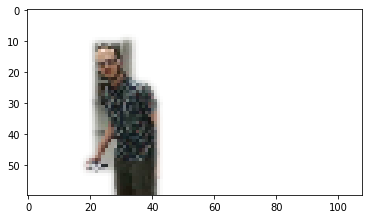

In [ ]:
### GrabCut example  

idx = 2
x = sample_poses[idx][0]
y = sample_poses[idx][1]
img = orig_img[sample_images[idx]]

person = (max(0, x-15), max(0, y-10), box_width+30, box_height+30) # (x, y, w, h) person area
face = (x, y, box_width, box_height) # (x, y, w, h) face area
edit = general_utils.image_background_replace_grabcut(img, cv2.GC_INIT_WITH_MASK, person, face, debug=True)
plt.imshow(edit[0])

#### Comparison with Canny

In [ ]:
ncols = 6
nrows = int(np.ceil(len(sample_images)/ncols))

# ### Save images

# save_path = visualization_folder + 'grabcut/samples/'
# general_utils.create_folder_if_not_exist(save_path)
# for counter, index in enumerate(sample_images):
#   cv2.imwrite(save_path + 'frame {:05d}.jpg'.format(dataset_start_index + index), cv2.cvtColor(orig_img[index], cv2.COLOR_RGB2BGR))

### Show pose on image

fig, ax = plt.subplots(nrows,ncols, figsize = (ncols*5,nrows*3), subplot_kw={'xticks': [], 'yticks': []})
fig.suptitle('Original with pose')
for counter, index in enumerate(sample_images):
  cell = general_utils.subplots_get_cell(len(sample_images), nrows, ncols, counter, ax)

  cell.imshow(orig_img[index])
  cell.set_title('f{} | x:{:.2f}, y:{:.2f}, z:{:.2f}, w:{:.2f}'.format(dataset_start_index + index, orig_y[0][index], orig_y[1][index], orig_y[2][index], orig_y[3][index]))

  rect = Rectangle(sample_poses[counter], box_width, box_height, linewidth=2, edgecolor='r', facecolor='none') # create a Rectangle patch
  cell.add_patch(rect) # add the patch to the Axes

### Canny simple background removal

fig, ax = plt.subplots(nrows,ncols, figsize = (ncols*5,nrows*3), subplot_kw={'xticks': [], 'yticks': []})
cmin, cmax = 100, 400
fig.suptitle('Canny simple, min{}-max{}'.format(cmin, cmax))
for counter, index in enumerate(sample_images):
  cell = general_utils.subplots_get_cell(len(sample_images), nrows, ncols, counter, ax)

  try:
    edit = general_utils.image_background_replace_canny(orig_img[index], cmin, cmax, l2gradient = True, 
                                    blur = 13, dilate_iter = 5, erode_iter = 5,
                                    transparent = False, replace_bg_images = None, save = False)
    cell.imshow(edit[0]) # it returns a single element array since 'replace_bg_images' is None
    cell.set_title('f {} | x:{:.2f}, y:{:.2f}, z:{:.2f}, w:{:.2f}'.format(dataset_start_index + index, orig_y[0][index], orig_y[1][index], orig_y[2][index], orig_y[3][index]))
  except:
    cell.set_facecolor('#ff8989')
    
### Canny enhanced background removal (with `mask_safe_area`)

canny_samples = [(100, 500)]
for cmin, cmax in canny_samples:
  fig, ax = plt.subplots(nrows,ncols, figsize = (ncols*5,nrows*3), subplot_kw={'xticks': [], 'yticks': []})
  fig.suptitle('Canny enhanced with mask_safe_area, min{}-max{}'.format(cmin, cmax))
  
  for counter, index in enumerate(sample_images):
    cell = general_utils.subplots_get_cell(len(sample_images), nrows, ncols, counter, ax)

    safe_area = (sample_poses[counter][0], sample_poses[counter][1], box_width, box_height) # (x, y, w, h)
    edit = general_utils.image_background_replace_canny(orig_img[index], cmin, cmax, l2gradient = True, mask_safe_area = safe_area)
    cell.imshow(edit[0]) # it returns a single element array since 'replace_bg_images' is None
    cell.set_title('f {} | x:{:.2f}, y:{:.2f}, z:{:.2f}, w:{:.2f}'.format(dataset_start_index + index, orig_y[0][index], orig_y[1][index], orig_y[2][index], orig_y[3][index]))

### Crop images

sample_images_crop = []

w = box_width
h = box_height

fig, ax = plt.subplots(nrows,ncols, figsize = (ncols*5,nrows*3), subplot_kw={'xticks': [], 'yticks': []})
fig.suptitle('Crop for only showing the person')
for counter, index in enumerate(sample_images):
  cell = general_utils.subplots_get_cell(len(sample_images), nrows, ncols, counter, ax)
  x = sample_poses[counter][0]
  y = sample_poses[counter][1]

  sample_images_crop.append(orig_img[index][max(0, y-5):y+h+30, max(0, x-15):x+w+15, :])
  cell.imshow(sample_images_crop[-1])
  cell.set_title('f {}'.format(dataset_start_index + index))

### Simple background removal on cropped images

fig, ax = plt.subplots(nrows,ncols, figsize = (ncols*5,nrows*3), subplot_kw={'xticks': [], 'yticks': []})
fig.suptitle('Apply background removal on cropped images')
for counter, index in enumerate(sample_images):
  cell = general_utils.subplots_get_cell(len(sample_images), nrows, ncols, counter, ax)
  edit = general_utils.image_background_replace_canny(sample_images_crop[counter], 100, 400, True, transparent=False)
  cell.imshow(edit[0])
  cell.set_title('f {}'.format(dataset_start_index + index))
    
### GrabCut background removal

for mode in [cv2.GC_INIT_WITH_RECT, cv2.GC_INIT_WITH_MASK]:
  fig, ax = plt.subplots(nrows,ncols, figsize = (ncols*5,nrows*3), subplot_kw={'xticks': [], 'yticks': []})
  fig.suptitle('GrabCut with {}'.format('person RECT' if mode == cv2.GC_INIT_WITH_RECT else 'face MASK'))

  for counter, index in enumerate(sample_images):
    cell = general_utils.subplots_get_cell(len(sample_images), nrows, ncols, counter, ax)
    x = sample_poses[counter][0]
    y = sample_poses[counter][1]

    rect = (max(0, x-15), max(0, y-10), box_width+30, box_height+30) # (x, y, w, h) person area
    face_area = (x, y, box_width, box_height) if mode == cv2.GC_INIT_WITH_MASK else None

    edit = general_utils.image_background_replace_grabcut(orig_img[index], mode, rect, face_area, smooth=True, iterations=2)
    cell.imshow(edit[0]) # it returns a single element array since 'replace_bg_images' is None
    cell.set_title('f {} | x:{:.2f}, y:{:.2f}, z:{:.2f}, w:{:.2f}'.format(dataset_start_index + index, orig_y[0][index], orig_y[1][index], orig_y[2][index], orig_y[3][index]))

Output hidden; open in https://colab.research.google.com to view.

#### Test on Nicky's Dataset

nicky_x shape (4129, 160, 160, 1)
nicky_y shape (4129, 4)


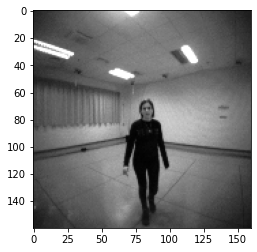

In [ ]:
pickle_nicky_path = new_datasets_folder + 'nicky/160x160HimaxMixedTrain_12_03_20_nicky.pickle'
pickle_others_path = new_datasets_folder + 'nicky/160x160HimaxTrain16_4_2020_others.pickle'

nicky_pickle = pd.read_pickle(pickle_nicky_path)
nicky_h = int(nicky_pickle['h'].values[0])
nicky_w = int(nicky_pickle['w'].values[0])
nicky_c = int(nicky_pickle['c'].values[0])

nicky_x = nicky_pickle['x'].values
nicky_x = np.vstack(nicky_x[:]).astype(np.float32)
nicky_x = np.reshape(nicky_x, (-1, nicky_h, nicky_w, nicky_c))
print('nicky_x shape', nicky_x.shape)

nicky_y = nicky_pickle['y'].values
nicky_y = np.vstack(nicky_y[:]).astype(np.float32)
print('nicky_y shape', nicky_y.shape)

plt.imshow(nicky_x[0][:,:,0], cmap='Greys_r')

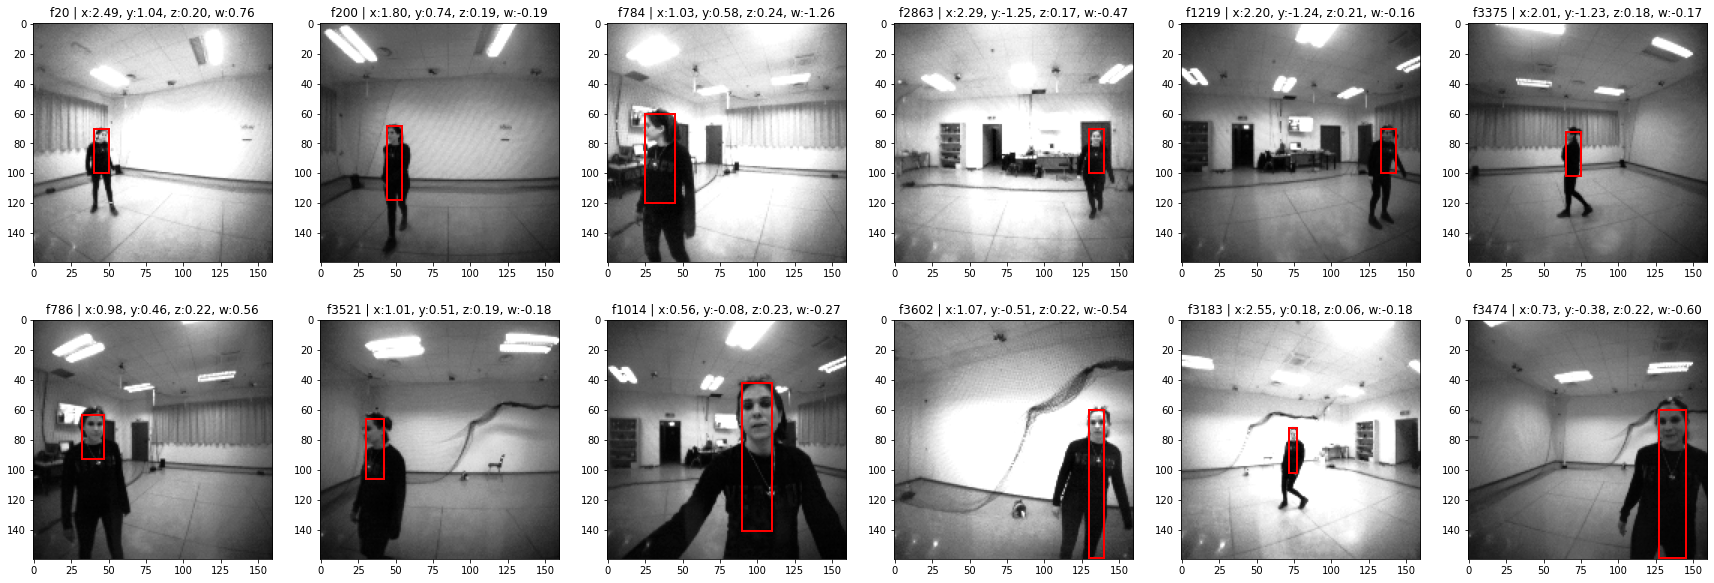

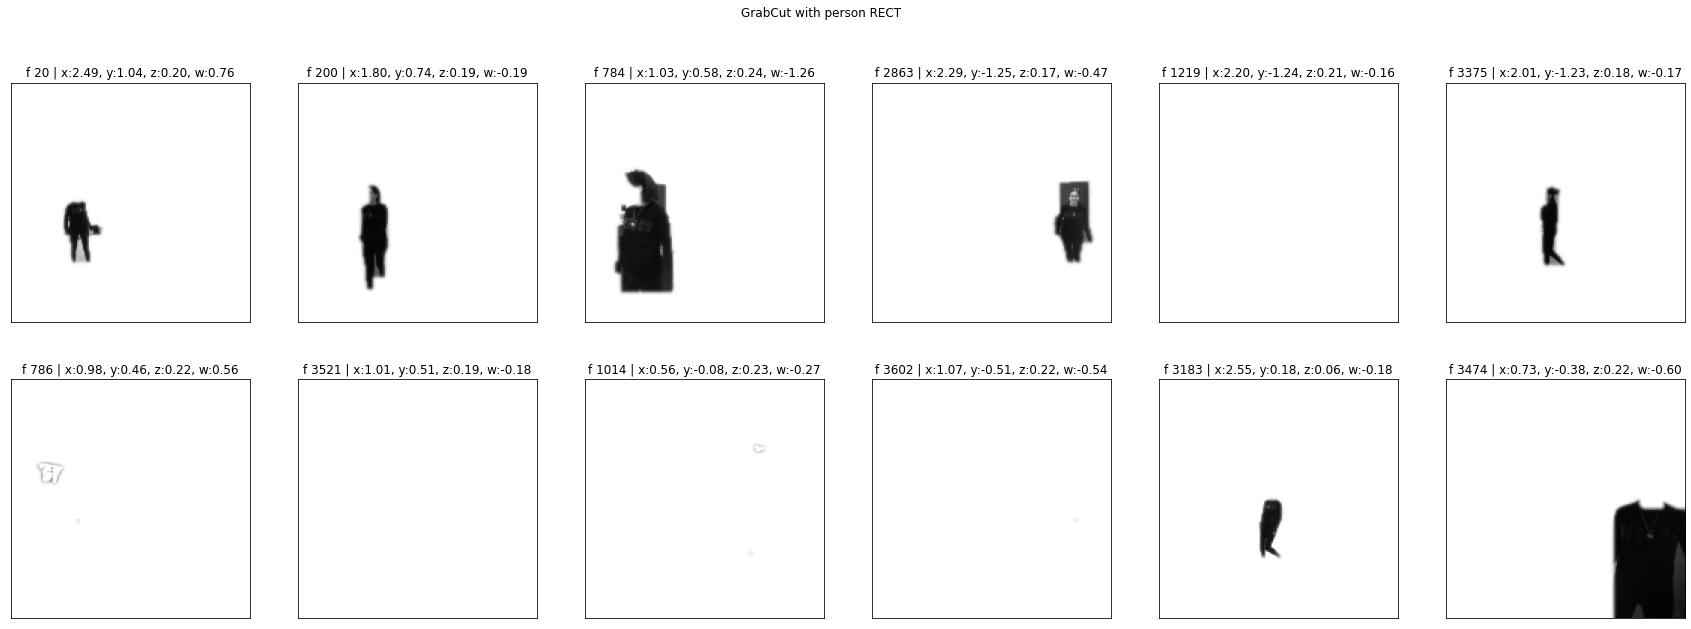

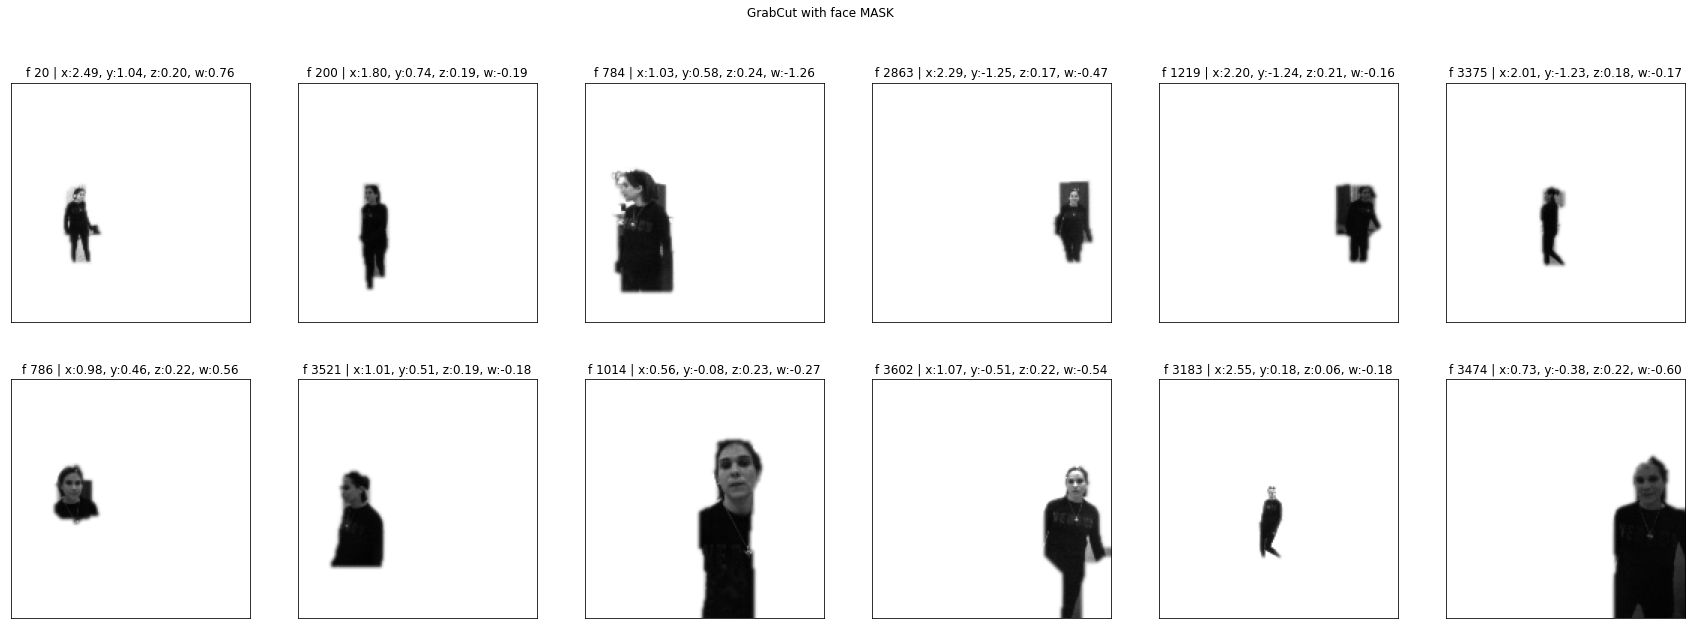

In [ ]:
nicky_images = [20, 200, 784, 2863, 1219, 3375,  
                 786, 3521, 1014, 3602, 3183, 3474]
nicky_poses = [(40, 70, 10, 30), (44, 68, 10, 50), (25, 60, 20, 60), (130, 70, 10, 30), (133, 70, 10, 30), (65, 72, 10, 30),
                (32, 63, 15, 30), (30, 66, 12, 40), (90, 42, 20, 99), (130, 60, 10, 99), (72, 72, 5, 30), (127, 60, 18, 99)]

ncols = 6
nrows = int(np.ceil(len(nicky_images)/ncols))

# ### Save images

# save_path = visualization_folder + 'grabcut/samples/'
# general_utils.create_folder_if_not_exist(save_path)
# for counter, index in enumerate(nicky_images):
#   cv2.imwrite(save_path + 'nicky {:05d}.jpg'.format(index), cv2.cvtColor(nicky_x[index], cv2.COLOR_RGB2BGR))

### Show poses

fig, ax = plt.subplots(nrows,ncols, figsize = (ncols*5,nrows*5))#, subplot_kw={'xticks': [], 'yticks': []})
for counter, index in enumerate(nicky_images):
  cell = general_utils.subplots_get_cell(len(nicky_images), nrows, ncols, counter, ax)

  cell.imshow(nicky_x[index][:,:,0], cmap='Greys_r')
  cell.set_title('f{} | x:{:.2f}, y:{:.2f}, z:{:.2f}, w:{:.2f}'.format(index, nicky_y[index][0], nicky_y[index][1], nicky_y[index][2], nicky_y[index][3]))
  
  rect = Rectangle(nicky_poses[counter], nicky_poses[counter][2], nicky_poses[counter][3], linewidth=2, edgecolor='r', facecolor='none')
  cell.add_patch(rect)

### GrabCut background removal

for mode in [cv2.GC_INIT_WITH_RECT, cv2.GC_INIT_WITH_MASK]:
  fig, ax = plt.subplots(nrows,ncols, figsize = (ncols*5,nrows*5), subplot_kw={'xticks': [], 'yticks': []})
  fig.suptitle('GrabCut with {}'.format('person RECT' if mode == cv2.GC_INIT_WITH_RECT else 'face MASK'))

  for counter, index in enumerate(nicky_images):
    cell = general_utils.subplots_get_cell(len(nicky_images), nrows, ncols, counter, ax)
    x = nicky_poses[counter][0]
    y = nicky_poses[counter][1]
    w = nicky_poses[counter][2]
    h = nicky_poses[counter][3]

    rect = (max(0, x-15), max(0, y-10), w+30, h+30) # (x, y, w, h) person area
    face_area = nicky_poses[counter] if mode == cv2.GC_INIT_WITH_MASK else None

    edit = general_utils.image_background_replace_grabcut(cv2.cvtColor(nicky_x[index], cv2.COLOR_GRAY2RGB).astype(np.uint8), mode, rect, face_area)
    cell.imshow(edit[0]) # it returns a single element array since 'replace_bg_images' is None
    cell.set_title('f {} | x:{:.2f}, y:{:.2f}, z:{:.2f}, w:{:.2f}'.format(index, nicky_y[index][0], nicky_y[index][1], nicky_y[index][2], nicky_y[index][3]))

## Human Detection

### YOLO with cvlib

https://github.com/arunponnusamy/cvlib

#### Settings

In [ ]:
!pip install cvlib
!pip install --upgrade cvlib

import cvlib as cv
from cvlib.object_detection import draw_bbox
import urllib

     |████████████████████████████████| 10.1MB 5.1MB/s 
  Created wheel for cvlib: filename=cvlib-0.2.5-cp36-none-any.whl size=10044206 sha256=db65f53a1aa22d9bcbfedf02186b0bce48474ef01d75012a9a962f2c42f0612c
  Stored in directory: /root/.cache/pip/wheels/6a/cb/43/ba188c823836640d8f22ee1f6ff792a0c83a8b66eabf52b219
  Created wheel for progressbar: filename=progressbar-2.5-cp36-none-any.whl size=12076 sha256=91c7df6452feedec78e8cfd1aca316bcb3d03ccc57ceb07183ee16a5b82c1db9
  Stored in directory: /root/.cache/pip/wheels/c0/e9/6b/ea01090205e285175842339aa3b491adeb4015206cda272ff0
Successfully built cvlib progressbar
Requirement already up-to-date: cvlib in /usr/local/lib/python3.6/dist-packages (0.2.5)


In [ ]:
from cvlib.object_detection import dest_dir as cvlib_destdir
print(cvlib_destdir)

import distutils
from distutils import dir_util

distutils.dir_util.copy_tree(visualization_folder + 'yolo/cvlib/cvlib_configuration', cvlib_destdir)
!ls '/root/.cvlib/object_detection/yolo/yolov3'

/root/.cvlib/object_detection/yolo/yolov3
yolov3.cfg	    yolov3-tiny.cfg	 yolov3.weights
yolov3_classes.txt  yolov3-tiny.weights


In [ ]:
def show_faces(img, detect_gender = False):
  
  img = np.copy(img)
  img_height = np.shape(img)[0]
  img_width = np.shape(img)[1]
  small_image = img_height < 150

  faces, confidences = cv.detect_face(img[:,:,:3])
  faces_count = len(faces)

  color = (0, 0, 255)
  thickness = 1 if small_image else 2
  font_scale = 0.4 if small_image else 2

  if faces_count == 0:
    cv2.putText(img, 'No faces', (2, img_height - 5), cv2.FONT_HERSHEY_SIMPLEX, font_scale, (0,0,0), thickness)

  else:
    for counter, box in enumerate(faces):
      x1, y1 = box[0], box[1]
      x2, y2 = box[2], box[3]
      w, h = x2 - x1, y2 - y1

      label = '{:.2f}%'.format(confidences[counter] * 100)

      if detect_gender:
        glabel, gconfidence = cv.detect_gender(img[y1:y2, x1:x2])
        best_prob = np.argmax(gconfidence)
        gender_prob = gconfidence[best_prob]
        gender_name = glabel[best_prob]
        label += ' ({} {:.0f}%)'.format(gender_name, gender_prob * 100)

      cv2.rectangle(img, (x1, y1), (x2, y2), color, thickness)
      if not small_image:
        cv2.putText(img, label, (x1, y1-4), cv2.FONT_HERSHEY_SIMPLEX, font_scale/4, color, thickness)

  return img, faces, confidences


def show_objects(img):
  
  img = np.copy(img)
  img_height = np.shape(img)[0]
  img_width = np.shape(img)[1]
  small_image = img_height < 150

  objects, labels, confidences = cv.detect_common_objects(img[:,:,:3])
  objects_count = len(objects)

  color = (0, 0, 255)
  thickness = 1 if small_image else 2
  font_scale = 0.4 if small_image else 2

  if objects_count == 0:
    cv2.putText(img, 'No objects', (2, img_height - 5), cv2.FONT_HERSHEY_SIMPLEX, font_scale, (0,0,0), thickness)

  else:
    for counter, box in enumerate(objects):
      x1, y1 = box[0], box[1]
      x2, y2 = box[2], box[3]
      w, h = x2 - x1, y2 - y1

      label = '{} {:.2f}%'.format(labels[counter], confidences[counter] * 100)

      cv2.rectangle(img, (x1, y1), (x2, y2), color, thickness)
      if not small_image:
        cv2.putText(img, label, (x1, y1-4), cv2.FONT_HERSHEY_SIMPLEX, font_scale/4, color, thickness)

  return img, objects, confidences

#### Demo

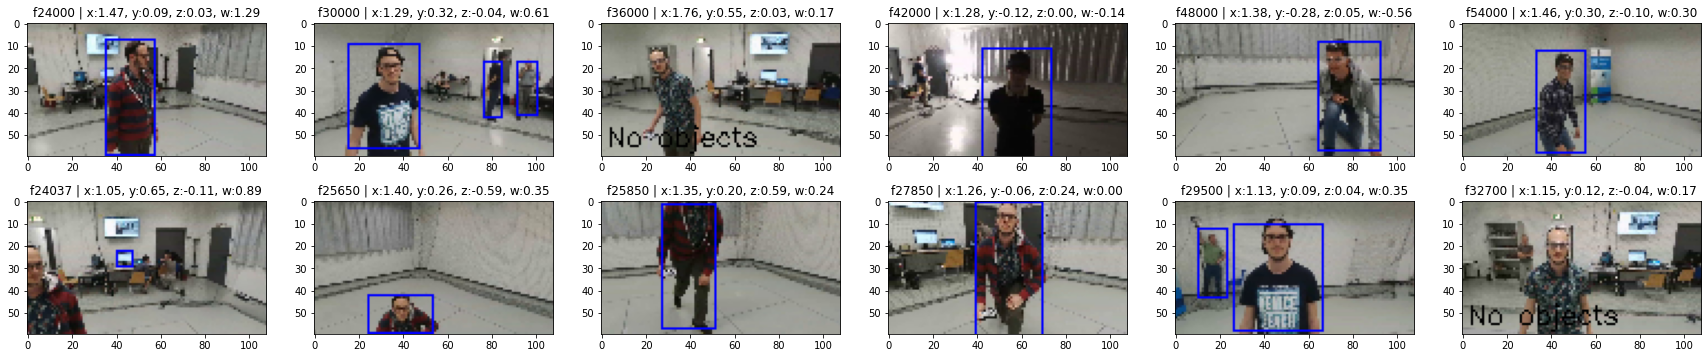

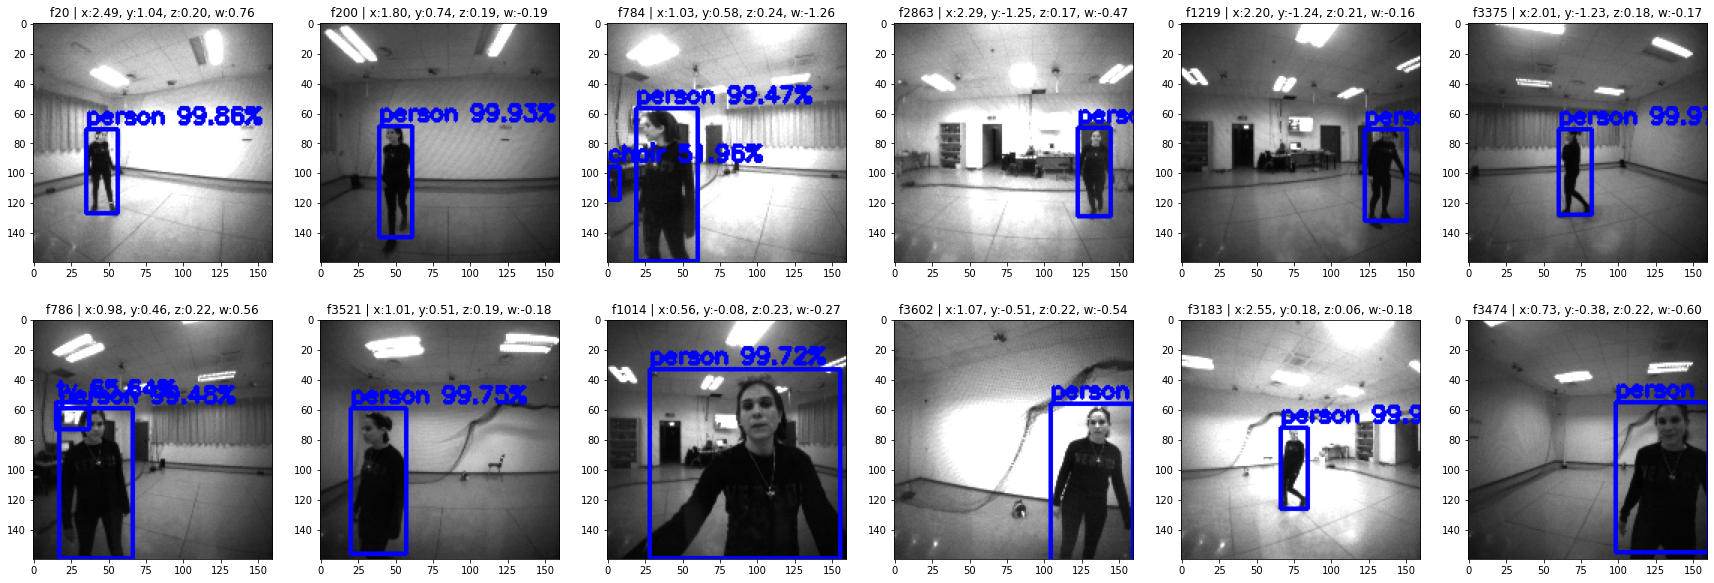

In [ ]:
### Dario's Dataset

ncols = 6
nrows = int(np.ceil(len(sample_images)/ncols))

fig, ax = plt.subplots(nrows,ncols, figsize = (ncols*5,nrows*3)) #, subplot_kw={'xticks': [], 'yticks': []})
for counter, index in enumerate(sample_images):
  cell = general_utils.subplots_get_cell(len(sample_images), nrows, ncols, counter, ax)

  img, boxes, confs = show_objects(orig_img[index])
  cell.imshow(img)
  cell.set_title('f{} | x:{:.2f}, y:{:.2f}, z:{:.2f}, w:{:.2f}'.format(dataset_start_index + index, orig_y[0][index], orig_y[1][index], orig_y[2][index], orig_y[3][index]))
  

### Nicky's Dataset (saving YOLO output)

nicky_yolo = []
ncols = 6
nrows = int(np.ceil(len(nicky_images)/ncols))

fig, ax = plt.subplots(nrows,ncols, figsize = (ncols*5,nrows*5)) #, subplot_kw={'xticks': [], 'yticks': []})
for counter, index in enumerate(nicky_images):
  cell = general_utils.subplots_get_cell(len(nicky_images), nrows, ncols, counter, ax)

  img, boxes, confs = show_objects(cv2.cvtColor(nicky_x[index], cv2.COLOR_GRAY2RGB).astype(np.uint8))
  cell.imshow(img)
  cell.set_title('f{} | x:{:.2f}, y:{:.2f}, z:{:.2f}, w:{:.2f}'.format(index, nicky_y[index][0], nicky_y[index][1], nicky_y[index][2], nicky_y[index][3]))

  if len(boxes) == 0:
    chosen_box = (None, None, None, None)
  elif len(boxes) == 1:
    chosen_box = boxes[0]
  elif len(boxes) > 1:
    chosen_box = max(boxes, key = lambda box: (box[2] - box[0])*(box[3] - box[1])) # get the largest rectangle => foreground person
  
  nicky_yolo.append(chosen_box) 

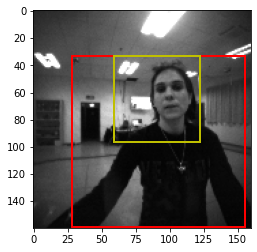

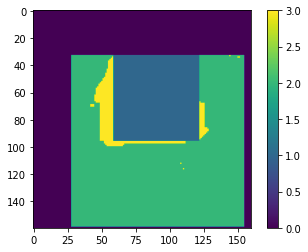

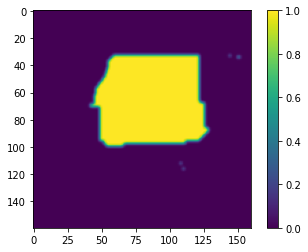

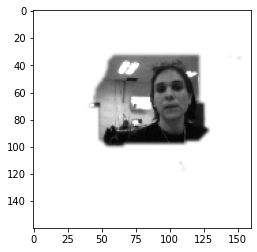

In [ ]:
### Single GrabCut debug example

mode == cv2.GC_INIT_WITH_MASK

idx = 8
img = nicky_x[nicky_images[idx]]

box = nicky_yolo[idx]
x1, y1 = box[0], box[1]
x2, y2 = box[2], box[3]
w, h = x2 - x1, y2 - y1

rect = (x1, y1, w, h) # (x, y, w, h) person area
face_area = (x1 + w//4, y1, w//2, h//2) if mode == cv2.GC_INIT_WITH_MASK else None

edit = general_utils.image_background_replace_grabcut(cv2.cvtColor(img, cv2.COLOR_GRAY2RGB).astype(np.uint8), mode, rect, face_area, debug=True)
plt.imshow(edit[0])

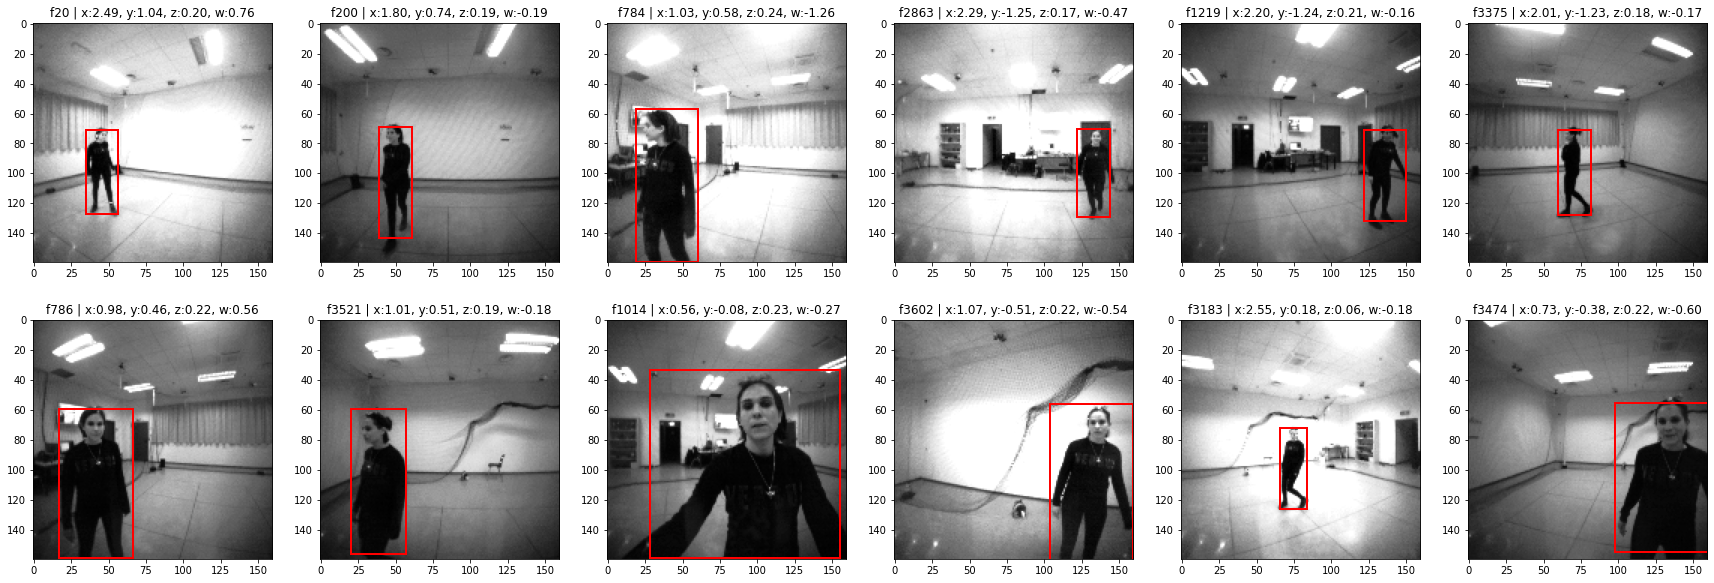

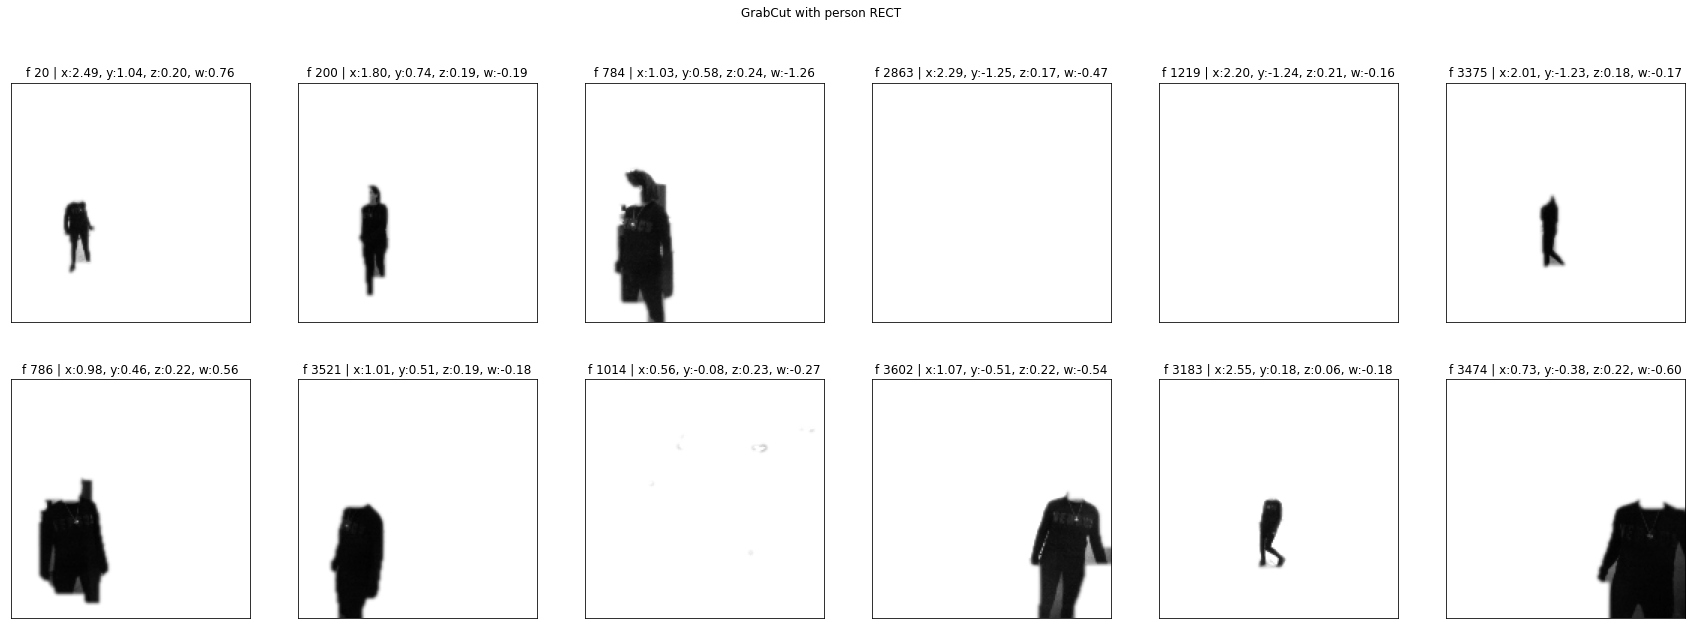

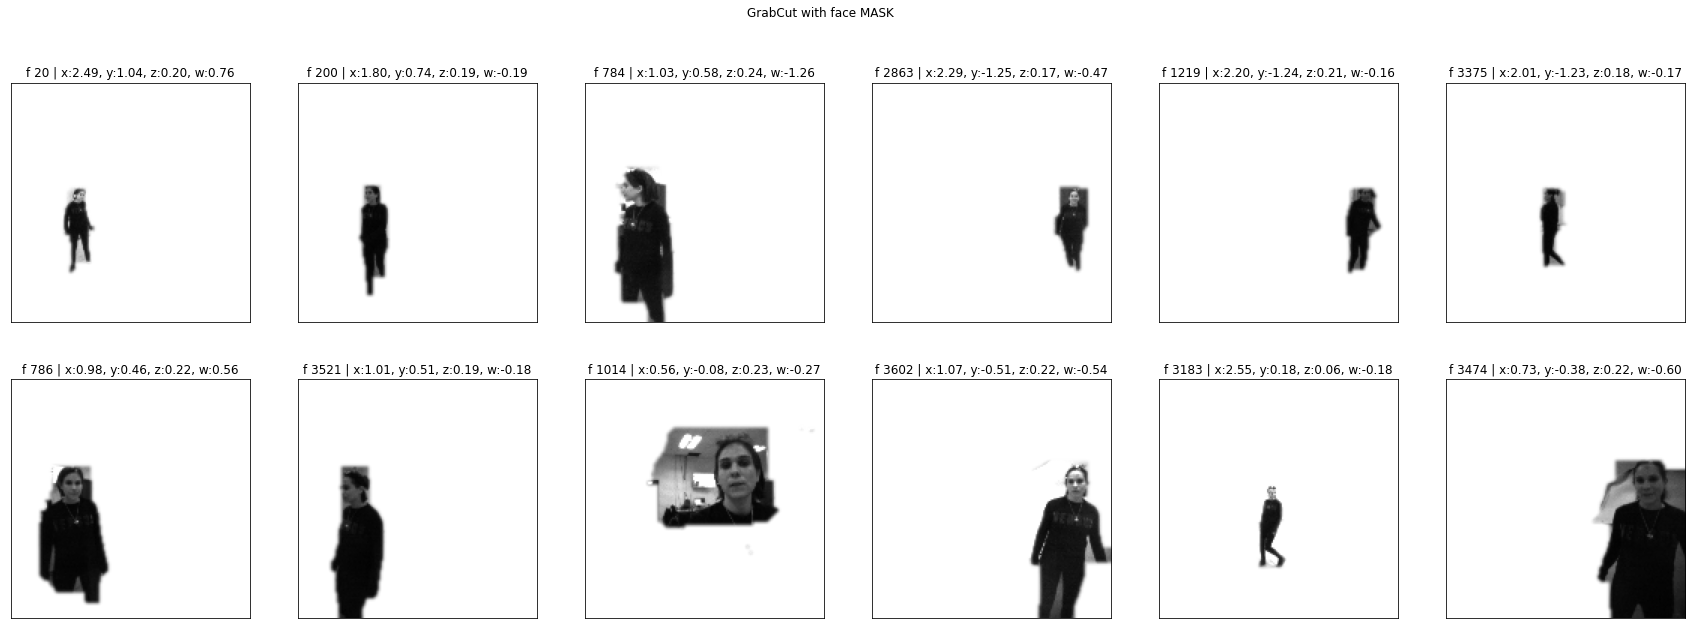

In [ ]:
### Show selected square

fig, ax = plt.subplots(nrows,ncols, figsize = (ncols*5,nrows*5))#, subplot_kw={'xticks': [], 'yticks': []})
for counter, index in enumerate(nicky_images):
  cell = general_utils.subplots_get_cell(len(nicky_images), nrows, ncols, counter, ax)

  box = nicky_yolo[counter]
  x1, y1 = box[0], box[1]
  x2, y2 = box[2], box[3]
  w, h = x2 - x1, y2 - y1

  cell.imshow(nicky_x[index][:,:,0], cmap='Greys_r')
  cell.set_title('f{} | x:{:.2f}, y:{:.2f}, z:{:.2f}, w:{:.2f}'.format(index, nicky_y[index][0], nicky_y[index][1], nicky_y[index][2], nicky_y[index][3]))

  rect = Rectangle((x1, y1), w, h, linewidth=2, edgecolor='r', facecolor='none')
  cell.add_patch(rect)

### GrabCut + YOLO

for mode in [cv2.GC_INIT_WITH_RECT, cv2.GC_INIT_WITH_MASK]:
  fig, ax = plt.subplots(nrows,ncols, figsize = (ncols*5,nrows*5), subplot_kw={'xticks': [], 'yticks': []})
  fig.suptitle('GrabCut with {}'.format('person RECT' if mode == cv2.GC_INIT_WITH_RECT else 'face MASK'))

  for counter, index in enumerate(nicky_images):
    cell = general_utils.subplots_get_cell(len(nicky_images), nrows, ncols, counter, ax)
    
    box = nicky_yolo[counter]
    if box[0] is None:
      continue
      
    x1, y1 = box[0], box[1]
    x2, y2 = box[2], box[3]
    w, h = x2 - x1, y2 - y1

    rect = (x1, y1, w, h) # (x, y, w, h) person area
    face_area = (x1 + w//4, y1, w//2, h//2) if mode == cv2.GC_INIT_WITH_MASK else None

    edit = general_utils.image_background_replace_grabcut(cv2.cvtColor(nicky_x[index], cv2.COLOR_GRAY2RGB).astype(np.uint8), mode, rect, face_area)
    cell.imshow(edit[0]) # it returns a single element array since 'replace_bg_images' is None
    cell.set_title('f {} | x:{:.2f}, y:{:.2f}, z:{:.2f}, w:{:.2f}'.format(index, nicky_y[index][0], nicky_y[index][1], nicky_y[index][2], nicky_y[index][3]))

#### GrabCut + YOLO test on random samples

Please note that `GC_INIT_WITH_MASK` approach is carried out by heuristically inferring face position in the image, give the person position. We draw a rectangle that starts at the top of the person, centered, with half the size of the person both in width and height. It often reveals to be a good approximation of the real head position.

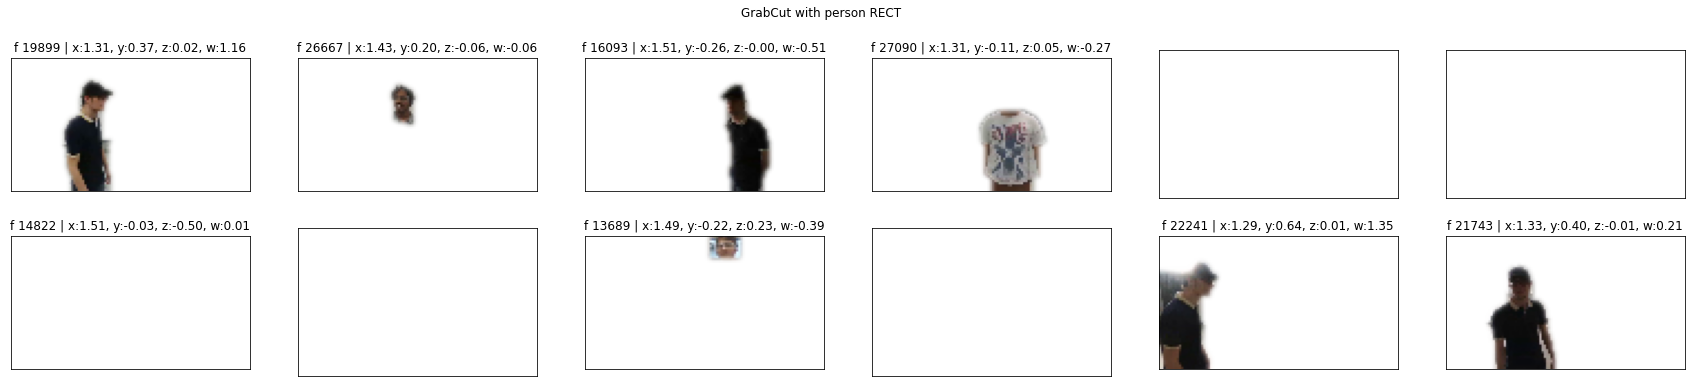

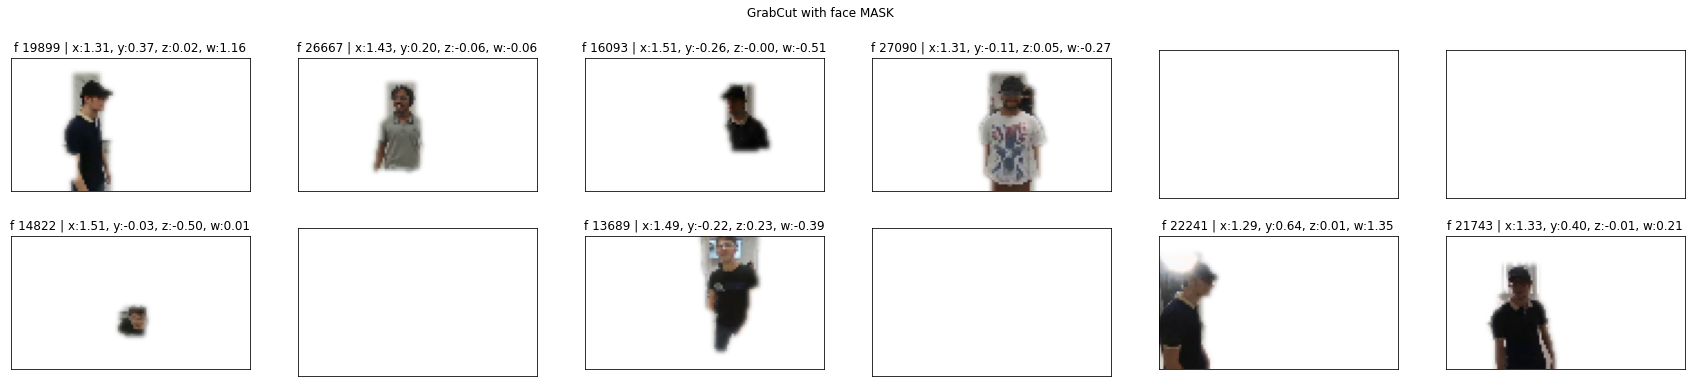

In [ ]:
### Dario

random_frames = np.random.choice(len(orig_img), 12)

ncols = 6
nrows = int(np.ceil(len(random_frames)/ncols))

for mode in [cv2.GC_INIT_WITH_RECT, cv2.GC_INIT_WITH_MASK]:

  fig, ax = plt.subplots(nrows,ncols, figsize = (ncols*5,nrows*3), subplot_kw={'xticks': [], 'yticks': []})
  fig.suptitle('GrabCut with {}'.format('person RECT' if mode == cv2.GC_INIT_WITH_RECT else 'face MASK'))

  for counter, index in enumerate(random_frames):
    cell = general_utils.subplots_get_cell(len(random_frames), nrows, ncols, counter, ax)
    
    # YOLO
    
    img, boxes, confs = show_objects(orig_img[index]) 

    if len(boxes) == 0:
      chosen_box = (None, None, None, None)
      continue
    elif len(boxes) == 1:
      chosen_box = boxes[0]
    elif len(boxes) > 1:
      chosen_box = max(boxes, key = lambda box: (box[2] - box[0]) * (box[3] - box[1])) # get the largest rectangle => foreground person

    x1, y1 = chosen_box[0], chosen_box[1]
    x2, y2 = chosen_box[2], chosen_box[3]
    w, h = x2 - x1, y2 - y1

    # GrabCut

    rect = (x1, y1, w, h) # (x, y, w, h) person area
    face_area = (x1 + w//4, y1, w//2, h//2) if mode == cv2.GC_INIT_WITH_MASK else None # (x, y, w, h) face area manually inferred

    edit = general_utils.image_background_replace_grabcut(orig_img[index], mode, rect, face_area)
    cell.imshow(edit[0]) # it returns a single element array since 'replace_bg_images' is None
    cell.set_title('f {} | x:{:.2f}, y:{:.2f}, z:{:.2f}, w:{:.2f}'.format(index, orig_y[0][index], orig_y[1][index], orig_y[2][index], orig_y[3][index]))

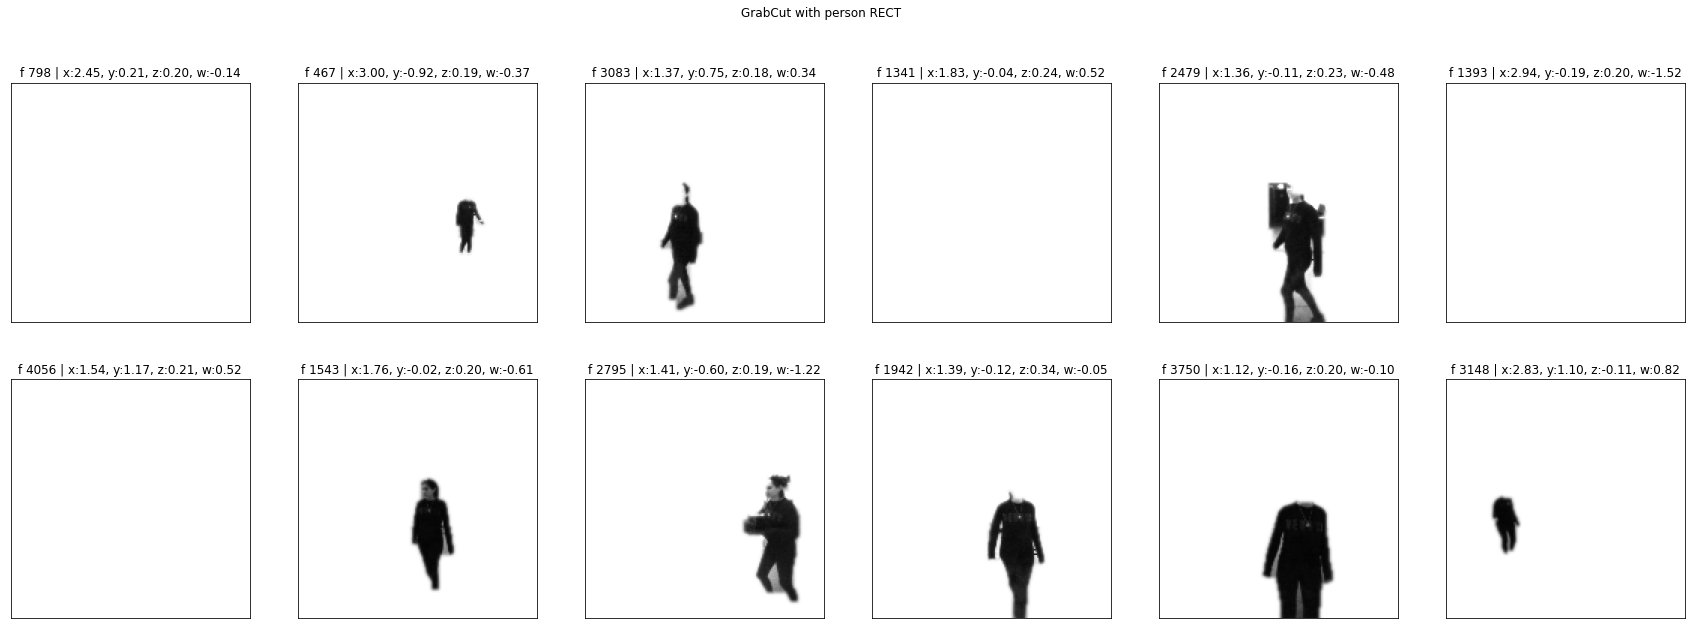

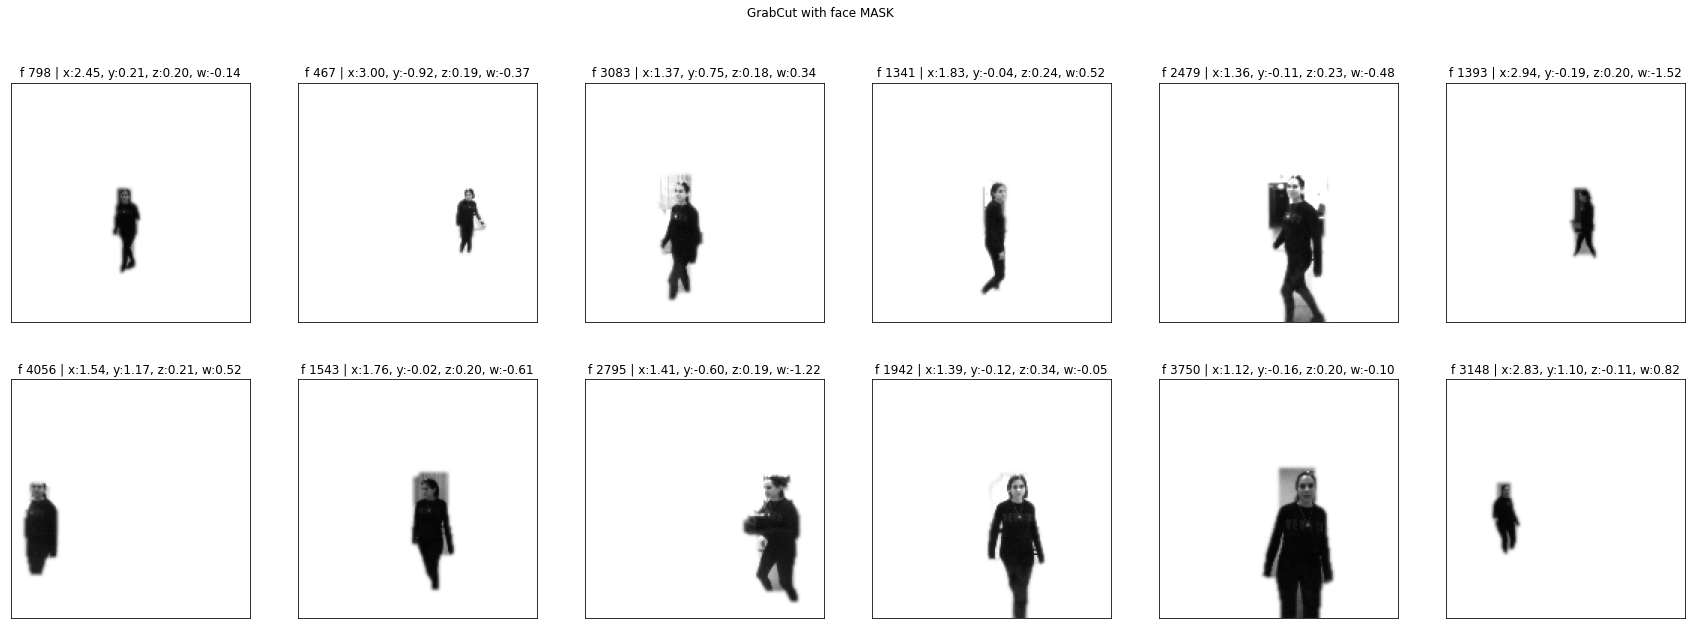

In [ ]:
### Nicky

random_frames = np.random.choice(len(nicky_x), 12)

ncols = 6
nrows = int(np.ceil(len(random_frames)/ncols))

for mode in [cv2.GC_INIT_WITH_RECT, cv2.GC_INIT_WITH_MASK]:

  fig, ax = plt.subplots(nrows,ncols, figsize = (ncols*5,nrows*5), subplot_kw={'xticks': [], 'yticks': []})
  fig.suptitle('GrabCut with {}'.format('person RECT' if mode == cv2.GC_INIT_WITH_RECT else 'face MASK'))

  for counter, index in enumerate(random_frames):
    cell = general_utils.subplots_get_cell(len(random_frames), nrows, ncols, counter, ax)
    
    # YOLO
    
    img, boxes, confs = show_objects(cv2.cvtColor(nicky_x[index], cv2.COLOR_GRAY2RGB).astype(np.uint8)) 

    if len(boxes) == 0:
      chosen_box = (None, None, None, None)
      continue
    elif len(boxes) == 1:
      chosen_box = boxes[0]
    elif len(boxes) > 1:
      chosen_box = max(boxes, key = lambda box: (box[2] - box[0]) * (box[3] - box[1])) # get the largest rectangle => foreground person

    x1, y1 = chosen_box[0], chosen_box[1]
    x2, y2 = chosen_box[2], chosen_box[3]
    w, h = x2 - x1, y2 - y1

    # GrabCut

    rect = (x1, y1, w, h) # (x, y, w, h) person area
    face_area = (x1 + w//4, y1, w//2, h//2) if mode == cv2.GC_INIT_WITH_MASK else None # (x, y, w, h) face area manually inferred

    edit = general_utils.image_background_replace_grabcut(cv2.cvtColor(nicky_x[index], cv2.COLOR_GRAY2RGB).astype(np.uint8), mode, rect, face_area)
    cell.imshow(edit[0]) # it returns a single element array since 'replace_bg_images' is None
    cell.set_title('f {} | x:{:.2f}, y:{:.2f}, z:{:.2f}, w:{:.2f}'.format(index, nicky_y[index][0], nicky_y[index][1], nicky_y[index][2], nicky_y[index][3]))

## Training experiments

In [ ]:
### Re-import
dataset_folder = new_datasets_folder + 'replace 31863 samples (start24k, skip12 = 2655) with 20 backgrounds - total 53120'
reimportpath = dataset_folder + '/20200928_164049_replacebg_df53120_1of1.pickle'
removebg_img, removebg_x, removebg_y, removebg_actual, removebg_odom = general_utils.get_dataset_from_pickle(reimportpath, dataset_keep_ratio=1)

Reading dataset from /content/drive/My Drive/_ USI/_ THESIS/proximity-quadrotor-learning/marco-test/new-datasets/replace 31863 samples (start24k, skip12 = 2655) with 20 backgrounds - total 53120/20200928_164049_replacebg_df53120_1of1.pickle
dataset original shape: (53120, 3)
dataset keep shape: 	(53120, 3)
img_data shape: 	(53120,)
x_data shape: 		(53120, 60, 108, 3)
y_data shape: 		(53120, 4)
odom_dataset shape: 	(53120, 2)
y_data_for_network shape cannot be computed because elements in the list have different shapes:
y_data_for_network number of variables 				 8
y_data_for_network single regression variable (0:4) 		 (53120,)
y_data_for_network single classification variable (4:8) 	 (53120, 3)


In [ ]:
### Model settings

train_img = removebg_img
train_x = removebg_x
train_y = removebg_y
train_actual = removebg_actual
train_odom = removebg_odom

var_index = None # (None: all, 4: x, 5: y, 6: z, 7: w)
retrain_all = True 
from_layer = 26 # (22: activation_6, 24: conv2d_9, 26: batch_normalization_7, 29: flatten_1)

timestr = time.strftime("%Y%m%d_%H%M%S")
# model_name = timestr + ' classic_{0}_total53k'.format('retrainfrom{0}'.format(from_layer) if retrain_all else 'simple')
model_name = timestr + ' 31k_start24k_skip12_bg20_{0}_total53k'.format('retrainfrom{0}'.format(from_layer) if retrain_all else 'simple')

export_folder = new_models_folder + model_name + '/'
general_utils.create_folder_if_not_exist(export_folder)
print(export_folder)

/content/drive/My Drive/_ USI/_ THESIS/proximity-quadrotor-learning/marco-test/new-models/20201014_132435 31k_start24k_skip12_bg20_retrainfrom26_total53k/


In [ ]:
### Training and save

model = keras_utils.network_create(original_model_path, retrain_all, var_index, view_summary = False, retrain_from_layer = from_layer)
model, history = keras_utils.network_train(model, train_x, train_y, var_index, use_early_stop = False)

keras_utils.network_stats(history, var_index, classification_only = False, view = True, save = False, save_folder = export_folder, save_name = model_name)
# keras_utils.network_save(model, export_folder, model_name, var_index, save_plot = False)

60


## Full training + GradCAM

In [ ]:
### Export models

train_img = removebg_img
train_x = removebg_x
train_y = removebg_y
train_actual = removebg_actual
train_odom = removebg_odom

retrain_all = False
from_layer = 24 # (22: activation_6, 24: conv2d_9, 26: batch_normalization_7, 29: flatten_1)

timestr = time.strftime("%Y%m%d_%H%M%S")
# model_name = timestr + ' 53k_start08k_classic_{0}_total53k'.format('retrainfrom{0}'.format(from_layer) if retrain_all else 'simple')
# model_name = timestr + ' 31k_start24k_skip12_bg20_{0}_total53k'.format('retrainfrom{0}'.format(from_layer) if retrain_all else 'simple')

exportvariants_folder = new_models_folder + model_name + '/'
general_utils.create_folder_if_not_exist(exportvariants_folder)
print(exportvariants_folder, '\n')

keras_utils.network_export_variants(
    original_model_path, exportvariants_folder, model_name, 
    train_x, train_y, retrain_all, from_layer, 
    use_lr_reducer = True, use_early_stop = False,
    view_stats=True, save_stats=True)

In [ ]:
### Import models

vis_model_all, vis_model_vars = keras_utils.network_import_variants(exportvariants_folder, model_name)

In [ ]:
### Select data

vis_max_samples = 1000
vis_index_start = 1
vis_img, vis_input, vis_actuals, vis_predictions_best, vis_index_start = keras_utils.gradcam_data_select_predict_transform(vis_model_vars, train_img, train_x, train_actual, vis_max_samples, vis_index_start)

In [ ]:
### GradCAM

max_frames = 50
nplotted = np.min([max_frames, vis_max_samples])

var_types = [0, 1, 2, 3] # X:0, Y:1, Z:2, W:3
loss_types = [0, 1, 2, 3] # low:0, medium:1, high:2, total:3
np.random.seed(general_utils.random_seed)
frames = np.random.choice(range(vis_input.shape[0]), nplotted, p = keras_utils.get_wave_distribution(vis_input.shape[0]))
per_var__loss_folder = visualization_folder + 'gradcam/replacebg/'

keras_utils.gradcam_comparison_varloss(
    vis_img, vis_input, vis_actuals, vis_predictions_best, vis_index_start,
    var_types, loss_types, vis_model_vars , frames, 
    per_var__loss_folder, notes = model_notes, title = True, save = True
)